# EDA


In [ ]:
import pandas as pd
df = pd.read_csv("spam.csv", encoding="latin-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
import pandas as pd
import re
from IPython.display import display
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de NLTK (solo la primera vez)
nltk.download("stopwords")

# Cargar lista de stopwords en inglés
STOPWORDS = set(stopwords.words("english"))

# Cargar dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

# Renombrar y quedarnos con columnas útiles
df = df.rename(columns={"v1": "label", "v2": "text"})[["label", "text"]].dropna()

print("Dataset cargado")
print("Dimensiones (filas, columnas):", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

print("\nPrimeras filas:")
display(df.head())

# Distribución de clases (ham/spam)
print("\nDistribución de clases (conteo):")
print(df["label"].value_counts())

print("\nDistribución de clases (proporción):")
print(df["label"].value_counts(normalize=True))

# Codificar etiqueta a binario: 1=spam, 0=ham
df["label"] = (df["label"].str.lower() == "spam").astype(int)

# ===============================================================
# 🔹 Limpieza del texto + eliminación de stopwords
# ===============================================================

URL_RE  = r'https?://\S+|www\.\S+'
MENT_RE = r'@\w+'

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(URL_RE,  ' ', s)          # quitar URLs
    s = re.sub(MENT_RE, ' ', s)          # quitar menciones
    s = re.sub(r'[^a-z0-9\s]', ' ', s)   # quitar símbolos
    s = re.sub(r'\s+', ' ', s).strip()   # quitar espacios extra

    # 🔸 quitar stopwords
    tokens = [word for word in s.split() if word not in STOPWORDS]
    return " ".join(tokens)

df["text_clean"] = df["text"].astype(str).apply(clean_text)

print("\nEjemplos antes vs después de limpieza:\n")
display(df[["text", "text_clean"]].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset cargado
Dimensiones (filas, columnas): (5572, 2)

Tipos de datos:
label    object
text     object
dtype: object

Primeras filas:


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



Distribución de clases (conteo):
label
ham     4825
spam     747
Name: count, dtype: int64

Distribución de clases (proporción):
label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

Ejemplos antes vs después de limpieza:



,text,text_clean
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though


📏 Estadísticas de longitud (en palabras):
Promedio: 9.40
Mediana:  7.0
Mínimo:   0
Máximo:   78


<Axes: >

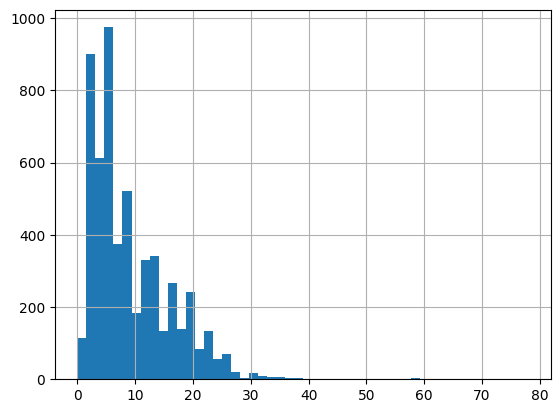

In [ ]:
# Longitud (en número de palabras) de cada mensaje limpio
df["msg_len"] = df["text_clean"].apply(lambda x: len(x.split()))

# Estadísticas descriptivas
promedio = df["msg_len"].mean()
mediana  = df["msg_len"].median()
maximo   = df["msg_len"].max()
minimo   = df["msg_len"].min()

print("📏 Estadísticas de longitud (en palabras):")
print(f"Promedio: {promedio:.2f}")
print(f"Mediana:  {mediana}")
print(f"Mínimo:   {minimo}")
print(f"Máximo:   {maximo}")

# Distribución opcional (para visualizar)
df["msg_len"].hist(bins=50)


# Transformacion de palabras a vectores y preparacion de hiperapametros

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Hiperparámetros clave:
vocab_size = 20000   # tamaño máximo del vocabulario (palabras más frecuentes)
max_len    = 40      # longitud fija de cada mensaje tras padding (SMS son cortos)

# 1) Ajustar el tokenizador sobre el texto LIMPIO
#    - oov_token reemplaza palabras fuera del vocabulario por un token especial
tok = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(df["text_clean"])

# 2) Texto -> Secuencias de índices (cada palabra = entero)
X = tok.texts_to_sequences(df["text_clean"])

# 3) Padding/Truncado para longitud fija:
#    - padding='post' añade ceros al final
#    - truncating='post' corta por el final mensajes muy largos
X = pad_sequences(X, maxlen=max_len, padding="post", truncating="post")

# 4) Etiquetas (0=ham, 1=spam) ya generadas en la fase de limpieza
y = df["label"].values

# 5) División Train/Valid estratificada:
#    - test_size=0.15 deja 15% para validación
#    - stratify=y mantiene la proporción ham/spam en ambos conjuntos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)

# 6) Confirmación de dimensiones
print("Tokenización completa.")
print("X_train shape:", X_train.shape)  # (n_train, max_len)
print("X_val shape:", X_val.shape)      # (n_val,   max_len)


Tokenización completa.
X_train shape: (4736, 40)
X_val shape: (836, 40)


MODELO A

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, optimizers, callbacks
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Hiperparámetros del modelo
embed_dim  = 64     # dimensión del embedding; documenta si comparas 32/64/128
hidden_dim = 64     # neuronas de la capa densa
drop_rate  = 0.30   # regularización para evitar sobreajuste
lr         = 1e-3   # learning rate

# 1) Definir arquitectura
inp = layers.Input(shape=(max_len,), name="input_ids")
x   = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name="embed")(inp)
x   = layers.GlobalAveragePooling1D(name="avg_pool")(x)
x   = layers.Dropout(drop_rate)(x)
x   = layers.Dense(
        hidden_dim, activation="relu",
        kernel_initializer=initializers.GlorotUniform(seed=42),
        name="dense_relu")(x)
x   = layers.Dropout(drop_rate)(x)
out = layers.Dense(1, activation="sigmoid", name="logit")(x)

modelA = tf.keras.Model(inp, out, name="A_EmbedAvg_Glorot")

# 2) Compilar
modelA.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 3) Callback: EarlyStopping para detener cuando ya no mejora en validación
es = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=3, restore_best_weights=True
)

# 4) Entrenar
histA = modelA.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=64,
    callbacks=[es],
    verbose=1
)

# 5) Evaluación con métricas clásicas de clasificación
proba = modelA.predict(X_val, verbose=0).ravel()
pred  = (proba > 0.5).astype(int)

acc = accuracy_score(y_val, pred)
pre = precision_score(y_val, pred)
rec = recall_score(y_val, pred)
f1  = f1_score(y_val, pred)
auc = roc_auc_score(y_val, proba)

print("\nRESULTADOS MODELO A")
print(f"Accuracy: {acc:.4f} | Precision: {pre:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
print("\nReporte de clasificación:\n", classification_report(y_val, pred, digits=4))


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8178 - loss: 0.4604 - val_accuracy: 0.8660 - val_loss: 0.3313
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8667 - loss: 0.3275 - val_accuracy: 0.8648 - val_loss: 0.3108
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8664 - loss: 0.2924 - val_accuracy: 0.8720 - val_loss: 0.2482
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8982 - loss: 0.2157 - val_accuracy: 0.9653 - val_loss: 0.1359
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9724 - loss: 0.1053 - val_accuracy: 0.9797 - val_loss: 0.0766
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9868 - loss: 0.0545 - val_accuracy: 0.9809 - val_loss: 0.0639
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9904 - loss: 0.0398 - val_accuracy: 0.9844 - val_loss: 0.0578
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9927 - loss: 0.0274 - val_accuracy: 0.9868 - v

MODELO B

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, optimizers, callbacks
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

embed_dim  = 64    # dimensión de los embeddings
hidden_dim = 64    # tamaño de la capa densa posterior a la extracción de features
drop_rate  = 0.40  # regularización para reducir sobreajuste
lr         = 1e-3  # tasa de aprendizaje

# Definición de la arquitectura
inp = layers.Input(shape=(max_len,), name="input_ids")                 # secuencia de índices
x   = layers.Embedding(input_dim=vocab_size,                           # vocabulario truncado a vocab_size
                       output_dim=embed_dim,                           # dimensión del embedding
                       name="embed")(inp)                              # capa Embedding = "Text Embeddings"

# BiLSTM para contexto bidireccional; return_sequences=True para mantener el eje temporal
x   = layers.Bidirectional(layers.LSTM(64, return_sequences=True),
                           name="bilstm")(x)

# Pooling: nos quedamos con la activación más alta (patrón más fuerte) a lo largo del tiempo
x   = layers.GlobalMaxPooling1D(name="gmp")(x)

# Dropout como regularización
x   = layers.Dropout(drop_rate)(x)

# Capa densa con ReLU; inicializador HeNormal recomendado con activaciones ReLU
x   = layers.Dense(hidden_dim,
                   activation="relu",
                   kernel_initializer=initializers.HeNormal(seed=42),
                   name="dense_relu")(x)

# Dropout adicional antes de la salida
x   = layers.Dropout(0.30)(x)

# Capa de salida sigmoide para probabilidad de clase positiva (1=spam)
out = layers.Dense(1, activation="sigmoid", name="logit")(x)

# Ensamble del modelo
modelB = tf.keras.Model(inp, out, name="B_Embed_BiLSTM_He")

# Compilación
# - loss: binary_crossentropy (tarea de clasificación binaria)
# - metrics: accuracy (reportaremos F1/AUC aparte con sklearn)
modelB.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento con EarlyStopping
# monitor='val_loss' para detener cuando no mejore la pérdida en validación
es = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                             patience=3, restore_best_weights=True)

histB = modelB.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# Evaluación en validación
# Convertimos probabilidades a etiquetas con umbral 0.5 (ajustable si optimizas F1/recall)
probaB = modelB.predict(X_val, verbose=0).ravel()
predB  = (probaB > 0.5).astype(int)

# Métricas clave para la rúbrica (además de accuracy):
# - Precision/Recall/F1: útiles con leve desbalance (ham > spam)
# - ROC-AUC: separabilidad global independiente del umbral
accB = accuracy_score(y_val, predB)
preB = precision_score(y_val, predB)
recB = recall_score(y_val, predB)
f1B  = f1_score(y_val, predB)
aucB = roc_auc_score(y_val, probaB)

print("\nRESULTADOS MODELO B (Embedding + BiLSTM)")
print(f"Accuracy: {accB:.4f} | Precision: {preB:.4f} | Recall: {recB:.4f} | F1: {f1B:.4f} | AUC: {aucB:.4f}")
print("\nReporte de clasificación:\n", classification_report(y_val, predB, digits=4))


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8523 - loss: 0.4655 - val_accuracy: 0.9390 - val_loss: 0.1799
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9700 - loss: 0.1097 - val_accuracy: 0.9833 - val_loss: 0.0698
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9938 - loss: 0.0242 - val_accuracy: 0.9833 - val_loss: 0.0717
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9949 - loss: 0.0136 - val_accuracy: 0.9844 - val_loss: 0.0741
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9987 - loss: 0.0073 - val_accuracy: 0.9821 - val_loss: 0.0877

RESULTADOS MODELO B (Embedding + BiLSTM)
Accuracy: 0.9833 | Precision: 0.9537 | Recall: 0.9196 | F1: 0.9364 | AUC: 0.9863

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9876    0.9931    0.9904       724
           1     0.9537    0.9196    0.9364       112

    accuracy                         0.9833       

MODELO C

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers, optimizers, callbacks
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Hiperparámetros del modelo
embed_dim  = 64     # dimensión del embedding
filters    = 128    # número de filtros Conv1D
kernel_sz  = 5      # tamaño del kernel
hidden_dim = 64     # neuronas de la densa
drop_rate  = 0.40   # regularización
lr         = 1e-3   # tasa de aprendizaje

# Definición de la arquitectura
inp = layers.Input(shape=(max_len,), name="input_ids")                 # secuencia de índices
x   = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,     # Capa de Text Embeddings
                       name="embed")(inp)

# Conv1D para n-gramas/disparadores locales de spam
x   = layers.Conv1D(filters=filters, kernel_size=kernel_sz,
                    activation="relu", padding="same",
                    name="conv")(x)

# Máximo global a lo largo del tiempo: se queda con la activación más fuerte por filtro
x   = layers.GlobalMaxPooling1D(name="gmp")(x)

# Regularización
x   = layers.Dropout(drop_rate)(x)

# Capa densa con ReLU; Glorot es una elección estándar sólida con ReLU
x   = layers.Dense(hidden_dim, activation="relu",
                   kernel_initializer=initializers.GlorotUniform(seed=42),
                   name="dense_relu")(x)

# Regularización adicional antes de la salida
x   = layers.Dropout(0.30)(x)

# Salida sigmoide (probabilidad de spam)
out = layers.Dense(1, activation="sigmoid", name="logit")(x)

modelC = tf.keras.Model(inp, out, name="C_Embed_Conv1D_Glorot")

# Compilación
modelC.compile(
    optimizer=optimizers.Adam(learning_rate=lr),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento
es = callbacks.EarlyStopping(monitor="val_loss", mode="min",
                             patience=3, restore_best_weights=True)

histC = modelC.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=64,
    callbacks=[es],
    verbose=1
)

# Evaluación en validación
probaC = modelC.predict(X_val, verbose=0).ravel()   # probabilidades
predC  = (probaC > 0.5).astype(int)                 # etiquetas (umbral 0.5)

accC = accuracy_score(y_val, predC)
preC = precision_score(y_val, predC)
recC = recall_score(y_val, predC)
f1C  = f1_score(y_val, predC)
aucC = roc_auc_score(y_val, probaC)

print("\nRESULTADOS MODELO C (Embedding + Conv1D)")
print(f"Accuracy: {accC:.4f} | Precision: {preC:.4f} | Recall: {recC:.4f} | F1: {f1C:.4f} | AUC: {aucC:.4f}")
print("\nReporte de clasificación:\n", classification_report(y_val, predC, digits=4))


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8343 - loss: 0.4909 - val_accuracy: 0.8660 - val_loss: 0.2589
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9265 - loss: 0.1715 - val_accuracy: 0.9868 - val_loss: 0.0636
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.9880 - val_loss: 0.0686
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9880 - val_loss: 0.0716
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9868 - val_loss: 0.0699

RESULTADOS MODELO C (Embedding + Conv1D)
Accuracy: 0.9868 | Precision: 0.9903 | Recall: 0.9107 | F1: 0.9488 | AUC: 0.9913

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9864    0.9986    0.9925       724
           1     0.9903    0.9107    0.9488       112

    accuracy                         0.9868       

TABLA COMPARATIVA

Tabla comparativa (ordenada por F1):


,model,acc,prec,rec,f1,auc
0,C_Embed_Conv1D_Glorot,0.986842,0.990291,0.910714,0.948837,0.991306
1,A_EmbedAvg_Glorot,0.986842,1.000000,0.901786,0.948357,0.989468
2,B_Embed_BiLSTM_He,0.983254,0.953704,0.919643,0.936364,0.986274



Mejor modelo elegido según F1: C_Embed_Conv1D_Glorot


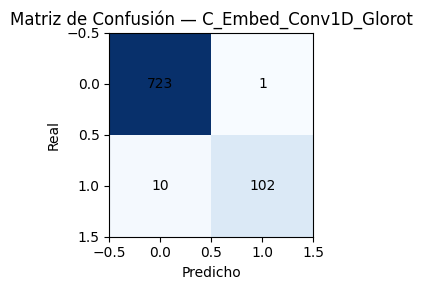

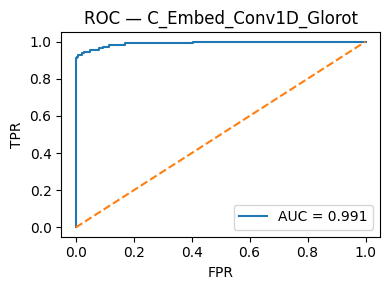

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
predA = (proba > 0.5).astype(int)
accA  = accuracy_score(y_val, predA)
preA  = precision_score(y_val, predA)
recA  = recall_score(y_val, predA)
f1A   = f1_score(y_val, predA)
aucA  = roc_auc_score(y_val, proba)

# Construir tabla comparativa
rows = [
    {"model":"A_EmbedAvg_Glorot",   "acc":accA, "prec":preA, "rec":recA, "f1":f1A, "auc":aucA},
    {"model":"B_Embed_BiLSTM_He",   "acc":accB, "prec":preB, "rec":recB, "f1":f1B, "auc":aucB},
    {"model":"C_Embed_Conv1D_Glorot","acc":accC,"prec":preC,"rec":recC,"f1":f1C,"auc":aucC},
]
res_df = pd.DataFrame(rows).sort_values("f1", ascending=False).reset_index(drop=True)

print("Tabla comparativa (ordenada por F1):")
display(res_df)

# Selección del mejor modelo según F1
best_name = res_df.loc[0, "model"]
print(f"\nMejor modelo elegido según F1: {best_name}")

# Obtener probabilidades del mejor para graficar ROC y matriz de confusión
if best_name == "A_EmbedAvg_Glorot":
    best_proba = proba
elif best_name == "B_Embed_BiLSTM_He":
    best_proba = probaB
else:
    best_proba = probaC

best_pred = (best_proba > 0.5).astype(int)

# Matriz de confusión
cm = confusion_matrix(y_val, best_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, cmap="Blues")
plt.title(f"Matriz de Confusión — {best_name}")
plt.xlabel("Predicho"); plt.ylabel("Real")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_val, best_proba)
auc_best = roc_auc_score(y_val, best_proba)

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC = {auc_best:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {best_name}")
plt.legend(); plt.tight_layout(); plt.show()
